# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [2]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [156]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.neighbors import BallTree

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, eps, min_pts):
        """
        Please add necessary algoritm parameters to class constructor.
        
        """
        NOISE = 0
        self.eps = eps
        self.min_pts = min_pts
        self.indexes = {NOISE:[]}
        
        self.C=0
        return
        
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        NOISE = 0
        self.x_len = len(X)
        self.features_count = X.shape[1]
        self.clusters = {NOISE:np.empty([0,self.features_count])}
        self.clustered = np.empty([0,self.features_count])
        self.visited = np.empty([0,self.features_count])
      
        for i,x in enumerate(X):
            if  (self.visited == x).all(1).any() == True: 
                continue
            self.visited = np.vstack((self.visited,x))
            nbr = self.find_neighbours(X[i:i+1],X) # set of neighbours
            if len(nbr) < self.min_pts:
                self.clusters[NOISE] = np.vstack((self.clusters[NOISE],x))
                self.indexes[NOISE].append(i)  
                    
            else:
                self.C += 1
                if self.C not in self.clusters:
                    self.clusters[self.C] = np.empty([0,self.features_count])
                    self.indexes[self.C] = []
                self.indexes[self.C].append(i)  
                #print("Запоняем кластер %s x =  %s, index  = %s " % (self.C,x,i) )
                #print(nbr) 
                self.expand_cluster(x, nbr, self.C, X)
                #print('что есть в кластере')   
                #print(self.clusters[self.C])  
            
          
        
        return self
    
    def expand_cluster(self,x,nbr,C,X):
        
        self.clusters[C] = np.vstack((self.clusters[C],x))
        self.clustered = np.vstack((self.clustered,x))
       
       # print(self.clustered)
        i = 0
        while i<len(nbr):
           
            x1 = nbr[i]
            self.visited = np.vstack((self.visited,x1))    
            nbr1 = self.find_neighbours(x1.reshape(1,self.features_count), X)
            
            if len(nbr1) >= self.min_pts:
                for elem in nbr1: 
                    if (nbr == elem).all(1).any() == False:
                        nbr = np.vstack((nbr,elem))
                        
            if  (self.clustered == x1).all(1).any() == False: 
             
                self.clusters[C] = np.vstack((self.clusters[C],x1))
                self.clustered = np.vstack((self.clustered,x1))
                self.indexes[self.C].append(i)
              
                if x1 in self.clusters[0]:
                    np.delete(self.clusters[0],x1)
            i += 1
    def find_neighbours(self,x,X):

        tree = BallTree(X) 
        distancies, ind = tree.query(x, k=self.min_pts+3)   
        ind = ind.ravel()
        distancies = distancies.ravel()
        neibs = np.empty([0,self.features_count])
        for i,neighbour in enumerate(ind): 
            if distancies[i] < self.eps:
                neibs = np.vstack((neibs,X[neighbour]))
        return neibs
    def find_neighbours_dist(self,x,X,min_pts):

        tree = BallTree(X) 
        distancies, ind = tree.query(x, k=min_pts)   
        ind = ind.ravel()
        distancies = distancies.ravel()
        return distancies
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        #return [random.randint(0,5) for r in range(self.x_len)]
        y_predict = []
        num = len(self.clusters)
        for i,x in enumerate(X):
            k=0
            while k < num:
                if (model.clusters[k] == x).all(1).any() == True: 
                    y_predict.append(k-1)
                k += 1     
        return y_predict
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    def find_criteria(self, k, X):
        distancies = []
        for i,x in enumerate(X):
            self.visited = np.vstack((self.visited,x))
            nbr = self.find_neighbours_dist(X[i:i+1],X,k+1) # set of neighbours
            dist_total = 0
            for dist in nbr[:k+1]:
                dist_total  = dist_total + dist
            mean_dist = dist_total/k    
            distancies.append(mean_dist)    
        return sorted(distancies)
            

In [157]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

In [158]:
model = Clustering( eps=0.5, min_pts=4)
model.fit(x_iris)




E:\Anaconda\lib\site-packages\ipykernel_launcher.py:83: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Clustering(eps=0.5, min_pts=4)

### Проверка работы алгоритма

E:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


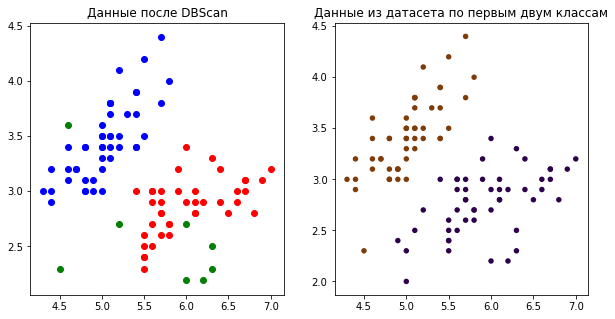

In [143]:
plt.figure(figsize=(10, 5))

fig1 = plt.subplot(1, 2, 1)
plt.gca().set_title('Данные после DBScan')
plt.scatter(model.clusters[1][:,0],model.clusters[1][:,1], c='b')
plt.scatter(model.clusters[2][:,0],model.clusters[2][:,1], c='r')
plt.scatter(model.clusters[0][:,0],model.clusters[0][:,1], c='g')


fig2 = plt.subplot(1, 2, 2)
plt.gca().set_title('Данные из датасета по первым двум классам')
plt.subplot(1, 2, 2)
plt.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)







Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

### Проверка метрики (adjusted rand score)

In [136]:
pred_iris = model.predict(x_iris)

In [137]:
pred_iris = model.predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, np.array(pred_iris) ))

Adjusted Rand index for iris is: 0.78


### Подбор параметра


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

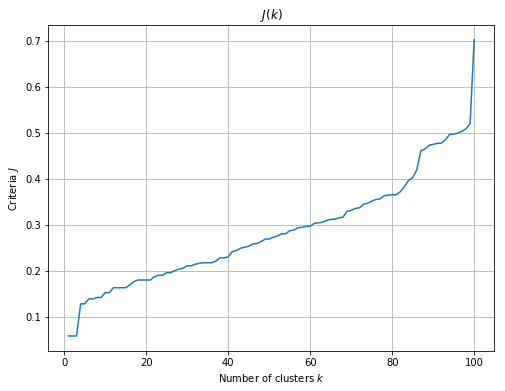

In [105]:
k = np.arange(1,101)
distancies = model.find_criteria(3, x_iris)
pl.figure(figsize=(8, 6))
pl.plot(k, distancies)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()


Получается eps  у нас оптимальнаот от  0,35 до 0,45 примерно

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

In [1]:
k = np.arange(10)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering()
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

NameError: name 'np' is not defined

### Проверка алгоритма на разных данных

In [162]:
X_circles = np.asarray(noisy_circles[0])
model = Clustering(eps=0.6, min_pts=7)
model.fit(X_circles)



Clustering(eps=0.6, min_pts=7)

E:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


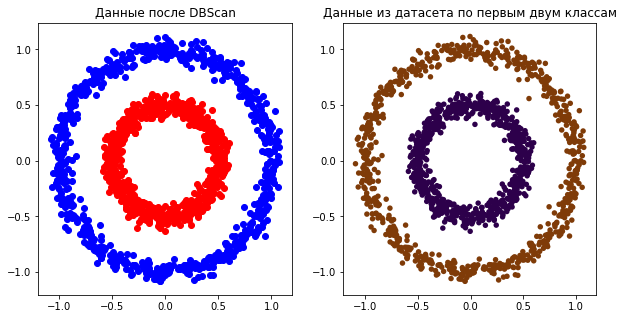

In [163]:
plt.figure(figsize=(10, 5))
fig1 = plt.subplot(1, 2, 1)
plt.gca().set_title('Данные после DBScan')
plt.scatter(model.clusters[1][:,0],model.clusters[1][:,1], c='b')
plt.scatter(model.clusters[2][:,0],model.clusters[2][:,1], c='r')
plt.scatter(model.clusters[0][:,0],model.clusters[0][:,1], c='g')


fig2 = plt.subplot(1, 2, 2)
plt.gca().set_title('Данные из датасета по первым двум классам')
plt.subplot(1, 2, 2)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=noisy_circles[1], cmap=pl.cm.PuOr, lw=0, s=30)


In [167]:
X_moons = np.asarray(noisy_moons[0])
model = Clustering(eps=0.5, min_pts=4)
model.fit(X_moons)


Clustering(eps=0.5, min_pts=4)

E:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


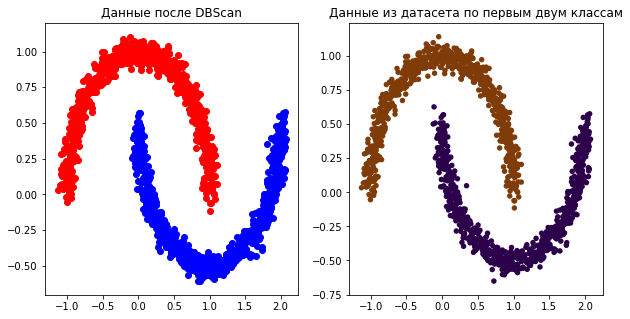

In [168]:
plt.figure(figsize=(10, 5))
fig1 = plt.subplot(1, 2, 1)
plt.gca().set_title('Данные после DBScan')
plt.scatter(model.clusters[1][:,0],model.clusters[1][:,1], c='b')
plt.scatter(model.clusters[2][:,0],model.clusters[2][:,1], c='r')
plt.scatter(model.clusters[0][:,0],model.clusters[0][:,1], c='g')


fig2 = plt.subplot(1, 2, 2)
plt.gca().set_title('Данные из датасета по первым двум классам')
plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=noisy_moons[1], cmap=pl.cm.PuOr, lw=0, s=30)

In [183]:
X_blobs = np.asarray(blobs[0])
model = Clustering(eps=0.9, min_pts=4)
model.fit(X_blobs)


Clustering(eps=0.9, min_pts=4)

E:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


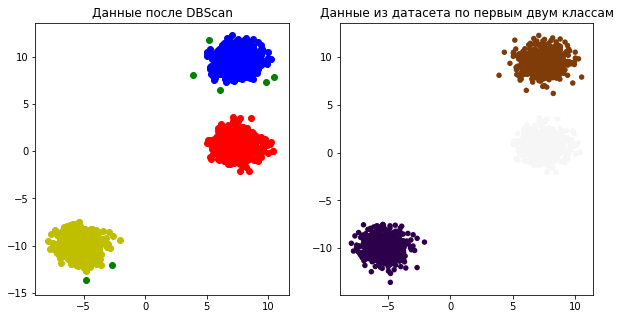

In [185]:
plt.figure(figsize=(10, 5))
fig1 = plt.subplot(1, 2, 1)
plt.gca().set_title('Данные после DBScan')
plt.scatter(model.clusters[1][:,0],model.clusters[1][:,1], c='b')
plt.scatter(model.clusters[2][:,0],model.clusters[2][:,1], c='r')
plt.scatter(model.clusters[3][:,0],model.clusters[3][:,1], c='y')
plt.scatter(model.clusters[0][:,0],model.clusters[0][:,1], c='g')


fig2 = plt.subplot(1, 2, 2)
plt.gca().set_title('Данные из датасета по первым двум классам')
plt.subplot(1, 2, 2)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=blobs[1], cmap=pl.cm.PuOr, lw=0, s=30)

In [187]:
X_no_structure = np.asarray(no_structure[0])
model = Clustering(eps=0.9, min_pts=4)
model.fit(X_no_structure)

Clustering(eps=0.9, min_pts=4)

E:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


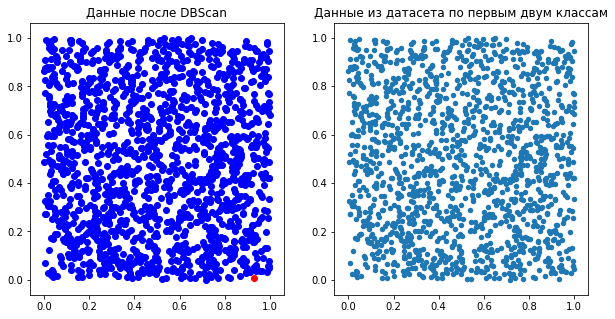

In [190]:
plt.figure(figsize=(10, 5))
fig1 = plt.subplot(1, 2, 1)
plt.gca().set_title('Данные после DBScan')
plt.scatter(model.clusters[1][:,0],model.clusters[1][:,1], c='b')
plt.scatter(model.clusters[2][:,0],model.clusters[2][:,1], c='r')
plt.scatter(model.clusters[0][:,0],model.clusters[0][:,1], c='g')


fig2 = plt.subplot(1, 2, 2)
plt.gca().set_title('Данные из датасета по первым двум классам')
plt.subplot(1, 2, 2)
plt.scatter(X_no_structure[:, 0], X_no_structure[:, 1], c=no_structure[1], cmap=pl.cm.PuOr, lw=0, s=30)

In [189]:
model.clusters

{0: array([], shape=(0, 2), dtype=float64), 1: array([[0.59945663, 0.24694133],
        [0.60007128, 0.24667963],
        [0.59964689, 0.25986194],
        ...,
        [0.03080259, 0.9858598 ],
        [0.00895354, 0.99022552],
        [0.04526159, 0.99571305]]), 2: array([[0.93120922, 0.00623743]])}

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

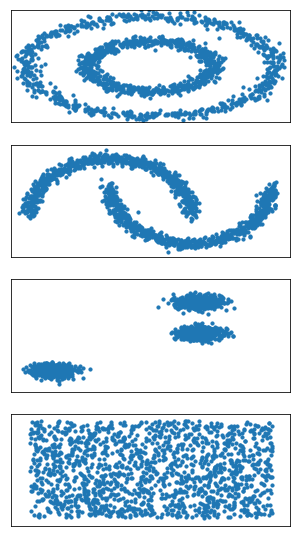

In [106]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

In [ ]:
k = 5
cls = Clustering()
y = cls.fit_predict(x)

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.